In [12]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import lightgbm as lgb

from lightgbm import LGBMRegressor

from sklearn.datasets import make_regression

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [13]:
# Generate synthetic regression dataset

X, y = make_regression(
    n_samples=1000, 
    n_features=20, 
    noise=0.1, 
    random_state=42)


In [14]:
# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

LightGBM requires datasets to be converted into its own lgb.Dataset format.

In [15]:
# Convert data into LightGBM dataset format

train_data = lgb.Dataset(X_train, label=y_train)

test_data = lgb.Dataset(X_test, label=y_test, reference=train_data )

In [16]:
import numpy as np

print("NaN in y_test:", np.isnan(y_test).sum())  # Should print 0
print("Unique values in y_test:", np.unique(y_test))  # Should show valid numbers


NaN in y_test: 0
Unique values in y_test: [-5.82061929e+02 -4.49770791e+02 -3.89227290e+02 -3.82071403e+02
 -3.77232139e+02 -3.72459879e+02 -3.45845914e+02 -3.35329607e+02
 -3.24445750e+02 -3.22973458e+02 -3.15399130e+02 -3.13476097e+02
 -3.03548236e+02 -3.00973573e+02 -2.90156786e+02 -2.84767383e+02
 -2.82790228e+02 -2.79211296e+02 -2.73141910e+02 -2.54744685e+02
 -2.49053745e+02 -2.43484147e+02 -2.34245657e+02 -2.13796426e+02
 -2.08811750e+02 -2.07627260e+02 -2.05368098e+02 -2.04544862e+02
 -1.96452892e+02 -1.92938982e+02 -1.88061271e+02 -1.83222278e+02
 -1.82064373e+02 -1.79560905e+02 -1.74095394e+02 -1.71602187e+02
 -1.70643498e+02 -1.70632842e+02 -1.65033332e+02 -1.50039509e+02
 -1.47795200e+02 -1.47076208e+02 -1.46423543e+02 -1.45065614e+02
 -1.44706915e+02 -1.43394306e+02 -1.39533293e+02 -1.39447959e+02
 -1.30861906e+02 -1.29958881e+02 -1.24244226e+02 -1.22915005e+02
 -1.21105975e+02 -1.18726525e+02 -1.14802767e+02 -1.11934453e+02
 -1.09630234e+02 -1.06165495e+02 -1.06034574e+02

Setting optimal parameters for regression.

In [17]:
params = {
    'objective': 'regression',  # Regression task
    'metric': 'rmse',           # Root Mean Squared Error (RMSE) as metric
    'boosting_type': 'gbdt',     # Gradient Boosting Decision Tree
    'learning_rate': 0.05,       # Step size shrinkage
    'num_leaves': 31,            # Maximum number of leaves in one tree
    'max_depth': -1,             # No depth limit (fully grown trees)
    'min_data_in_leaf': 20,      # Minimum samples per leaf
    'feature_fraction': 0.8,     # Use 80% of features per iteration
    'bagging_fraction': 0.8,     # Use 80% of data per iteration
    'bagging_freq': 5,           # Perform bagging every 5 iterations
    'verbose': -1                # Suppress warnings
}


We'll use early stopping to avoid overfitting.

In [18]:
# Train the model


model = lgb.train(
    params, 
    train_data, 
    valid_sets=[test_data],
    num_boost_round=500, 
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # Fix for early stopping
        lgb.log_evaluation(period=50)  # Fix for verbose output (replaces verbose_eval)
    ]
    )

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 80.1971
[100]	valid_0's rmse: 55.8804
[150]	valid_0's rmse: 49.5204
[200]	valid_0's rmse: 47.9942
[250]	valid_0's rmse: 47.0275
[300]	valid_0's rmse: 46.7324
[350]	valid_0's rmse: 46.6308
[400]	valid_0's rmse: 46.5989
[450]	valid_0's rmse: 46.4293
[500]	valid_0's rmse: 46.4096
Did not meet early stopping. Best iteration is:
[455]	valid_0's rmse: 46.3951


 Model Evaluation

In [19]:
# Make predictions

y_pred=model.predict(X_test)

In [20]:
# Calculate metrics

mae = mean_absolute_error(y_test,y_pred)

mse = mean_squared_error(y_test,y_pred)

rmse = np.sqrt(mse)

r2 = r2_score(y_test,y_pred)

In [21]:
# Print results


print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 34.9534
Mean Squared Error (MSE): 2152.5090
Root Mean Squared Error (RMSE): 46.3951
R² Score: 0.9444


Feature Importance

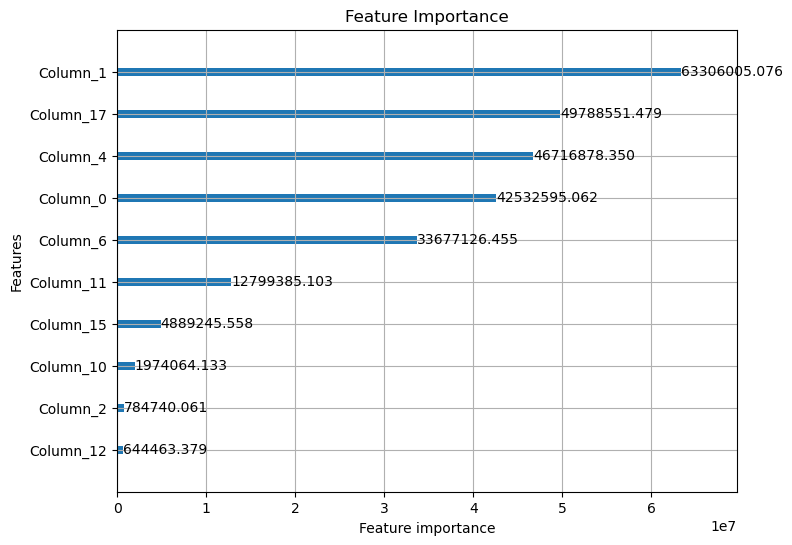

In [22]:
# Plot Feature Importance

lgb.plot_importance(model, max_num_features=10, importance_type='gain', figsize=(8,6))

plt.title("Feature Importance")

plt.show()

Hyperparameter Tuning

We'll use GridSearchCV to find the best parameters.

Hyperparameter Tuning

In [23]:
# Define parameter grid
param_grid = {

    'num_leaves': [20, 31, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    
}

In [24]:
# Initialize model

lgbm = LGBMRegressor()

In [25]:
# Perform Grid Search

grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='r2', n_jobs=-1)

In [26]:
grid_search.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4270
[LightGBM] [Info] Total Bins 4274
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 20
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 20
[LightGBM] [Info] Start training from score 0.261361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 4.305124
[LightGBM] [Info] Total Bins 4273
[LightGBM] [Info] Number of data points in the train set: 64

GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 500],
                         'num_leaves': [20, 31, 40]},
             scoring='r2')

In [27]:
# Best Parameters

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 20}


In [28]:
# Evaluate best model

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

In [29]:
print(f"Optimized R² Score: {r2_score(y_test, y_pred_best):.4f}")


Optimized R² Score: 0.9304
